# NLP Final Project: Sentiment Analysis Using LSTM vs Transformer

> ## Research Question
Can LSTM and Transformer-based models produce significantly different sentiment predictions when the training data sequence is altered?

Specifically, I investigate how order affects model learning by training each model twice: once with the original order and once with shuffled reviews.


NOTES
* explain im training with train, val and test.
* explain why i chose tinybert ofer distilbert.
* explain why i use lemmas when training lstm, and why i use raw when training tinybert.
* lstm uses adam optimizer, tinybert uses adamW optimizer.


## Imports and definitions

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import ast
import matplotlib.colors as mcolors

#### Load stats

In [41]:
stats_file_path = "../logs/stats.log"
stats_log = open(stats_file_path).readlines()[-1]
stats = json.loads(stats_log)

eval_file_path = "../logs/evaluation_results.log"
with open(eval_file_path, "r") as f:
    eval_logs = [json.loads(line.strip()) for line in f if line.strip()]

#### Visualization functions

In [27]:
def set_chart_style(base_color="#08519c"):
    """
    Sets global chart style using a base color.
    """
    plt.style.use('default')
    plt.rcParams.update({
        'figure.figsize': (6, 4),
        'axes.grid': True,
        'grid.color': 'lightgray',
        'grid.linestyle': '--',
        'grid.alpha': 0.7,
        'axes.titlesize': 14,
        'axes.labelsize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'axes.edgecolor': 'gray',
        'axes.spines.top': False,
        'axes.spines.right': False,
        'font.family': 'sans-serif',
        'font.sans-serif': ['DejaVu Sans'],
        'axes.prop_cycle': plt.cycler(color=[base_color])
    })
    sns.set_style("whitegrid")

def get_color_gradient(base_color="#08519c", n=4):
    """
    Generate n gradient shades of the base color from light to dark.
    """
    return [mcolors.to_hex(c) for c in 
            mcolors.LinearSegmentedColormap.from_list("", ["white", base_color])(np.linspace(0.3, 1, n))]

In [28]:
def plot_spacy_funnel(ax, stages, values, title="spaCy Pipeline Funnel", base_color="#08519c"):
    """
    Funnel chart with gradient color from bottom (bold) to top (light).
    """
    set_chart_style(base_color)
    funnel_colors = get_color_gradient(base_color, len(stages))[::-1]  # bottom = bold

    bars = ax.barh(stages, values, color=funnel_colors)
    ax.invert_yaxis()
    ax.set_title(title)
    ax.set_xlabel("Count")
    ax.set_ylabel("Stage")
    ax.grid(axis='x', linestyle='--', alpha=0.5)

    # Annotate each bar with its count (centered)
    for bar, value in zip(bars, values):
        ax.text(value / 2,                       # horizontal center
                bar.get_y() + bar.get_height() / 2,  # vertical center
                f"{value:,}",                    # format with comma
                va='center', ha='center', color='black', fontsize=12)

In [37]:
def plot_metric_comparison(df, metrics, group_col='Order', model_col='Model', label_col='Order',
                           color_map=None, base_color="#08519c", title="Model Performance"):
    """
    Plots grouped bar charts comparing multiple metrics (e.g., Accuracy, F1 Score)
    between original and shuffled datasets.
    """
    set_chart_style(base_color)
    
    if not color_map:
        color_map = {
            'Original': base_color,
            'Shuffled': get_color_gradient(base_color, 2)[0]  # fallback lighter
        }

    models = df[model_col].unique()
    groups = df[group_col].unique()
    bar_width = 0.35

    fig, axes = plt.subplots(1, len(metrics), sharey=True)
    if len(metrics) == 1:
        axes = [axes]

    for ax, (metric_col, metric_label) in zip(axes, metrics):
        for i, group in enumerate(groups):
            # Align the subset to the models to avoid shape mismatch
            subset = df[df[group_col] == group].set_index(model_col).reindex(models)
            values = subset[metric_col].values

            ax.bar(
                [x + i * bar_width for x in range(len(models))],
                values,
                width=bar_width,
                label=group,
                color=color_map.get(group, base_color)
            )

        ax.set_xticks([x + bar_width / 2 for x in range(len(models))])
        ax.set_xticklabels(models)
        ax.set_title(f"{metric_label} Comparison")
        ax.set_xlabel("Model")
        ax.grid(axis='y', linestyle='--', alpha=0.5)

    axes[0].set_ylabel("Score")
    axes[-1].legend(title=label_col)
    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [39]:
def plot_confusion_matrices(matrices, labels, titles, from_raw_cm=False):
    """
    matrices     : list of (y_true, y_pred) OR raw confusion matrices if from_raw_cm=True
    labels       : class labels (e.g., ['Neg', 'Pos'])
    titles       : chart titles per subplot
    from_raw_cm  : if True, matrices are already confusion matrices
    """
    set_chart_style()
    n = len(matrices)
    rows = (n + 1) // 2
    fig, axes = plt.subplots(rows, 2, sharex=True, sharey=True)
    axes = axes.flatten()

    for i, (item, title) in enumerate(zip(matrices, titles)):
        cm = item if from_raw_cm else confusion_matrix(*item, labels=labels)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=labels, yticklabels=labels, ax=axes[i])
        axes[i].set_title(title)
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("Actual")

    # Hide unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

## 1. Dataset Selection
I'll use the **IMDb Movie Reviews** dataset, a popular benchmark for binary sentiment classification (positive/negative). Each review includes a label indicating the sentiment.

In [42]:
imdb_df = pd.read_csv("../data/IMDB_Dataset_small.csv")
imdb_df['label'] = imdb_df['sentiment'].map({'positive': 1, 'negative': 0})
imdb_df.head()

,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


## 2-4. Tokenizer, Lemmatizer and Tagger
Those core steps will apply only to the LSTM model data, since TinyBERT works better with raw and untokenized text.
Tokenization using a custom spaCy pipeline.

#### Word count reduction by parsing stages

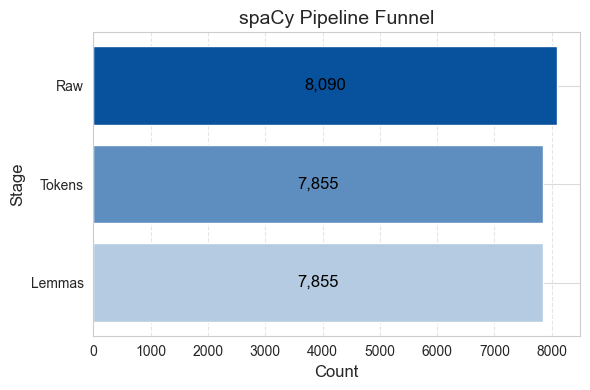

In [43]:
stages = ['Raw', 'Tokens', 'Lemmas']
values = [stats['raw'], stats['tokens'], stats['lemmas']]

set_chart_style("#08519c")
fig, ax = plt.subplots(figsize=(6, 4))
plot_spacy_funnel(ax, stages, values)
plt.tight_layout()
plt.show()

#### Top 10 of POS tags

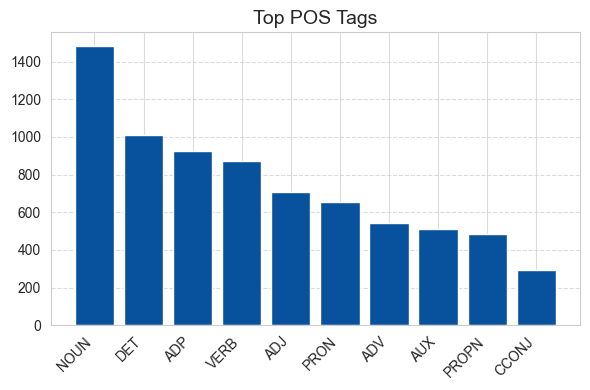

In [44]:
pos_counts = stats['pos_count']
labels = list(pos_counts.keys())
counts = list(pos_counts.values())

plt.figure()
plt.bar(labels, counts)
plt.xticks(rotation=45, ha='right')
plt.title("Top POS Tags")
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

#### Distribution of token lenghts
To better understand the typical length of tokenized reviews in the dataset, I analyzed their distribution. This helps determine an appropriate **padding length before model training**.

To preserve around **85% of the data**, I’ll use the 85th percentile of token lengths to define the maximum sequence length (`max_len`) for padding.

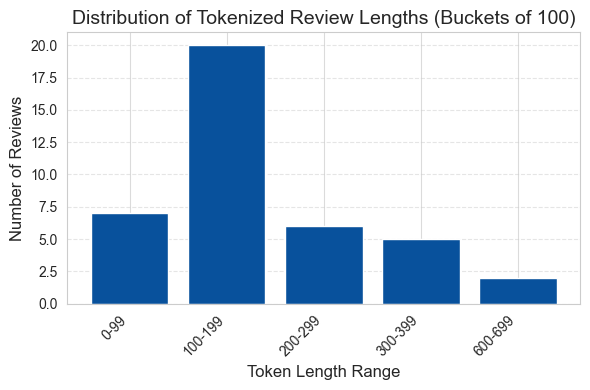

In [45]:
len_buckets = stats["len_buckets"]
bucket_labels = list(len_buckets.keys())
bucket_values = list(len_buckets.values())

# Plot
plt.bar(bucket_labels, bucket_values)
plt.xticks(rotation=45, ha='right')
plt.title("Distribution of Tokenized Review Lengths (Buckets of 100)")
plt.xlabel("Token Length Range")
plt.ylabel("Number of Reviews")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## 5. Word Embedding (Word2Vec)
I'll use pre-trained Word2Vec vectors to convert lemmas into dense vectors.

## 6. Sentiment Analysis with LSTM (Long Short Term Model)
LSTM is trained on Word2Vec-embedded sequences, using lemmas. Lemmas are popular when using Word2Vec + LSTM, and tends to give more generalizable embeddings. 

### Model Architecture:
LSTM (Long Short-Term Memory) processes input sequentially, making it sensitive to the order of input tokens.

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png" alt="LSTM Architecture" width="500"/>

### Why Order Matters:
LSTMs are time-series models. Earlier inputs affect future states. Shuffling disrupts the temporal patterns they rely on.

## 7. Sentiment Analysis with Transformer (TinyBERT)
### Model Architecture:
Transformers use self-attention and positional encodings to model all tokens in parallel.

### Why Order Matters Less:
Transformers don't rely on previous hidden states. They learn dependencies regardless of position (with help from position embeddings).

## 8. Train Both Models

Explicit here the parameters of training.
two steps of training, first will be training with the original order of the dataset. and later with the suffled order.

#### LSTM

#### TinyBERT
Transformers like TinyBERT rely on subword tokenization, not on traditional word-level tokenization. This is why I'll train the model on the raw reviews, and not tokens.

## 9. Evaluation Metrics
We use:
- **Accuracy**: Overall correct predictions.
- **F1 Score**: Balance of precision and recall.
- **Confusion Matrix**: True vs. predicted breakdown.

In [46]:
eval_df = pd.DataFrame(eval_logs)
# Optional: Format accuracy as percentage string for display
eval_df['Accuracy'] = (eval_df['test_accuracy'] * 100).round(2).astype(str) + '%'
eval_df['F1 Score'] = eval_df['f1_score'].round(4)
eval_df['Model'] = eval_df['model_name'].apply(lambda name: 'LSTM' if 'LSTM' in name else 'TinyBERT')
eval_df['Order'] = eval_df['model_name'].apply(lambda name: 'Original' if 'original' in name else 'Shuffled')
evaluation = eval_df[['Model', 'Order', 'Accuracy', 'F1 Score']]
evaluation

,Model,Order,Accuracy,F1 Score
0,LSTM,Original,50.0%,0.0000
1,LSTM,Shuffled,50.0%,0.0000
2,TinyBERT,Original,60.0%,0.7143
3,TinyBERT,Shuffled,50.0%,0.6667


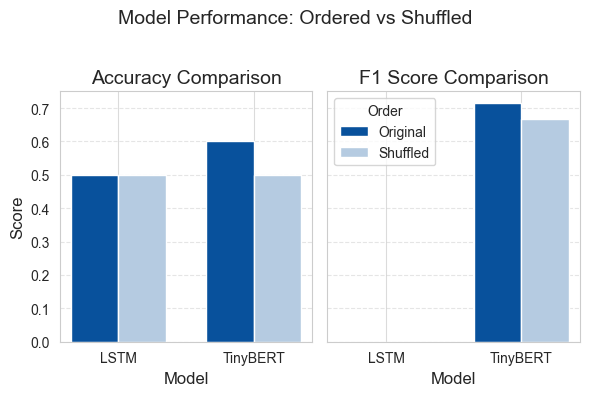

In [47]:
df_plot = eval_df.copy()
df_plot['Accuracy'] = df_plot['Accuracy'].str.replace('%', '').astype(float) / 100

plot_metric_comparison(
    df=df_plot,
    metrics=[('Accuracy', 'Accuracy'), ('F1 Score', 'F1 Score')],
    base_color="#08519c",
    title="Model Performance: Ordered vs Shuffled"
)

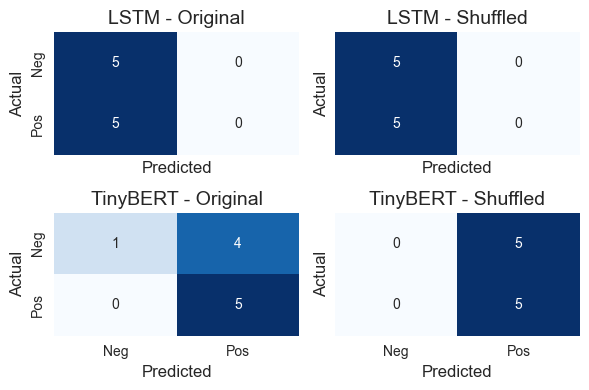

In [48]:
eval_df['confusion_matrix'] = eval_df['confusion_matrix'].apply(ast.literal_eval)

# Step: prepare confusion matrices and titles
model_types = ['LSTM', 'TinyBERT']
orders = ['Original', 'Shuffled']

matrices = []
titles = []

for model in model_types:
    for order in orders:
        row = eval_df[(eval_df['Model'] == model) & (eval_df['Order'] == order)].iloc[0]
        matrices.append(row['confusion_matrix'])
        titles.append(f"{model} - {order}")

# Now call the unified function
plot_confusion_matrices(
    matrices=matrices,
    labels=['Neg', 'Pos'],
    titles=titles,
    from_raw_cm=True
)

## 10. Results & Comparison
### LSTM:
LSTM shows high sensitivity to order changes, reflecting how temporal patterns affect its performance.

### Transformer:
Less affected by input order due to parallel processing and attention mechanisms.

## Interpretation
- **LSTM**: Learns over sequences. Changing order disrupts its internal state learning.
- **Transformer**: Learns over attention patterns. Order affects it mildly.

### Summary:
This research demonstrates that **model architecture affects sensitivity to input order**. In sequence-based data like sentiment over time, this consideration is crucial when selecting a model type.